# Benchmarking cloud generation functions

---------------------

## Using cloudmask from random Landsat images

Rather than generating artificial clouds using, say, Perlin or simplex noise, we can just use the cloud masks that come with Landsat images (any Landsat image, but obviously not an image that is part of our dataset). Using cloud cover of 20-30% right now. Not sure if there is any downside to doing this versus Perlin/Simplex noise, but couldn't figure out a way to generate cloud cover server side in GEE.

Another important point is that the cloud cover is really more for aesthetic purposes, at least until we use the classifer to predict all cloud-covered pixels. To speed things up, we could just take a random subset of the sampled points as our "cloud pixels" for testing. But then again, we ultimately want to have a figure of red/green, incorrect/correct predictions over cloud areas, which we would need artificial clouds for.

All of these methods for generating artificial cloud cover assume that cloud presence is equally probable in all pixels of an image, which isn't necessarily true if we are dealing with mountains /cloud shadow areas, large water bodies, etc. Doesn't seem too important at this point though. 

---------------------

### Understanding the parameters for noise generation
http://libnoise.sourceforge.net/tutorials/tutorial4.html

https://flafla2.github.io/2014/08/09/perlinnoise.html

## 2-dimensional Perlin noise generation
Benefit of generating native cloud cover is that we can control the % cloud cover and create a f(cloud_cover)=model accuracy relationship when testing our flood prediction models.

This Perlin noise script is from https://github.com/ruslangrimov/perlin-noise-python-numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product, count

from matplotlib.colors import LinearSegmentedColormap

In [1]:
def generate_unit_vectors(n):
    'Generates matrix NxN of unit length vectors'
    phi = np.random.uniform(0, 2*np.pi, (n, n))
    v = np.stack((np.cos(phi), np.sin(phi)), axis=-1)
    return v


# quintic interpolation
def qz(t):
    return t * t * t * (t * (t * 6 - 15) + 10)


# cubic interpolation
def cz(t):
    return -2 * t * t * t + 3 * t * t


def generate_2D_perlin_noise(size, ns):
    '''
    generate_2D_perlin_noise(size, ns)
    Generate 2D array of size x size filled with Perlin noise.
    Parameters
    ----------
    size : int
        Size of 2D array size x size.
    ns : int
        Distance between nodes.
    Returns
    -------
    m : ndarray
        The 2D array filled with Perlin noise.
    '''
    nc = int(size / ns)  # number of nodes
    grid_size = int(size / ns + 1)  # number of points in grid

    # generate grid of vectors
    v = generate_unit_vectors(grid_size)

    # generate some constans in advance
    ad, ar = np.arange(ns), np.arange(-ns, 0, 1)

    # vectors from each of the 4 nearest nodes to a point in the NSxNS patch
    vd = np.zeros((ns, ns, 4, 1, 2))
    for (l1, l2), c in zip(product((ad, ar), repeat=2), count()):
        vd[:, :, c, 0] = np.stack(np.meshgrid(l2, l1, indexing='xy'), axis=2)

    # interpolation coefficients
    d = qz(np.stack((np.zeros((ns, ns, 2)),
                     np.stack(np.meshgrid(ad, ad, indexing='ij'), axis=2)),
           axis=2) / ns)
    d[:, :, 0] = 1 - d[:, :, 1]
    # make copy and reshape for convenience
    d0 = d[..., 0].copy().reshape(ns, ns, 1, 2)
    d1 = d[..., 1].copy().reshape(ns, ns, 2, 1)

    # make an empy matrix
    m = np.zeros((size, size))
    # reshape for convenience
    t = m.reshape(nc, ns, nc, ns)

    # calculate values for a NSxNS patch at a time
    for i, j in product(np.arange(nc), repeat=2):  # loop through the grid
        # get four node vectors
        av = v[i:i+2, j:j+2].reshape(4, 2, 1)
        # 'vector from node to point' dot 'node vector'
        at = np.matmul(vd, av).reshape(ns, ns, 2, 2)
        # horizontal and vertical interpolation
        t[i, :, j, :] = np.matmul(np.matmul(d0, at), d1).reshape(ns, ns)

    return m

img = generate_2D_perlin_noise(200, 20)
plt.imshow(img, cmap=cm.gray)

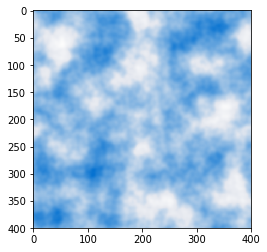

In [2]:
# Generate "sky" using multiple layers with different node distances
img0 = generate_2D_perlin_noise(400, 80)
img1 = generate_2D_perlin_noise(400, 40)
img2 = generate_2D_perlin_noise(400, 20)
img3 = generate_2D_perlin_noise(400, 10)

img = (img0 + img1 + img2 + img3) / 4
cmap = LinearSegmentedColormap.from_list('sky',
                                        [(0, '#0572D1'),
                                         (0.75, '#E5E8EF'),
                                         (1, '#FCFCFC')])
img = cm.ScalarMappable(cmap=cmap).to_rgba(img)
plt.imshow(img)

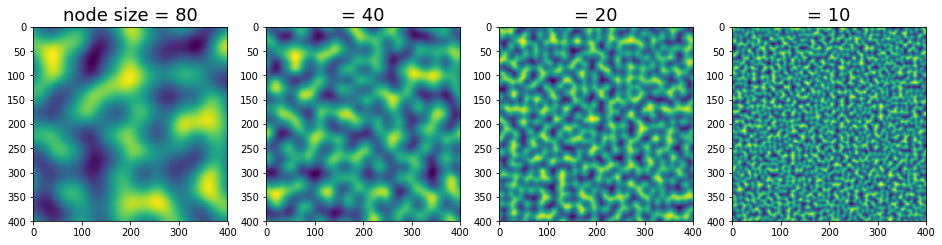

In [3]:
# Testing parameters of the noise generator

plt.figure(figsize=(16,16))
columns = 4
images = [img0, img1, img2, img3]
# images = [img0<0.8, img1<0.8, img2<0.8, img3<0.8]
titles = ['node size = 80', '= 40', '= 20', '= 10']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

We can make a more realistic binary cloud mask by adding together multiple images generated with different node distances, and then thresholding the summed image. Thresholding by percentiles also conveniently gives us a range of different cloud covers that can be used to create the accuracy curve of the model.

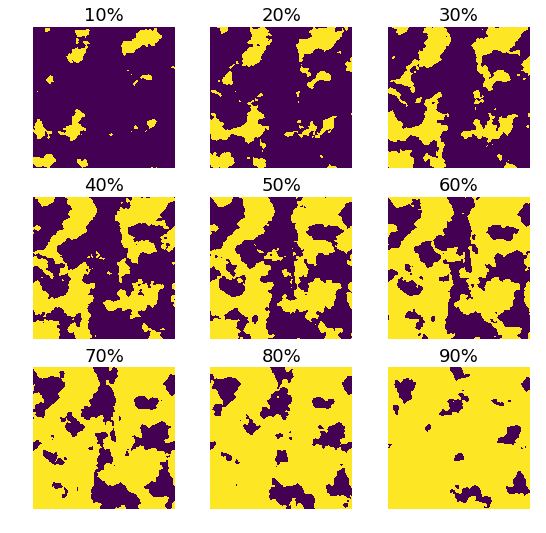

In [12]:
img_sum = np.sum(img, axis=2)

plt.figure(figsize=(9,12))
columns = 3
images = [img_sum<np.percentile(img_sum, 10),
          img_sum<np.percentile(img_sum, 20),
          img_sum<np.percentile(img_sum, 30),
         img_sum<np.percentile(img_sum, 40),
          img_sum<np.percentile(img_sum, 50),
         img_sum<np.percentile(img_sum, 60),
          img_sum<np.percentile(img_sum, 70),
         img_sum<np.percentile(img_sum, 80),
         img_sum<np.percentile(img_sum, 90)]
titles = ['10%', '20%', '30%','40%','50%',
         '60%','70%','80%','90%']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.axis('off')
    plt.imshow(image)
    plt.colorbar

### Problem:
The code above only creates a square NxN matrix, whereas Landsat images are not square. We need NxM matrix. 

## 2-dimensional *non-square* Perlin noise generation
From https://github.com/caseman/noise

In [2]:
import sys
from noise import pnoise2, snoise2
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

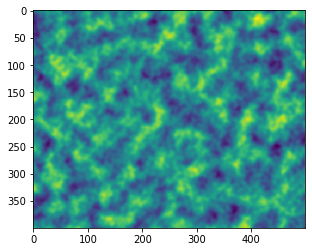

In [51]:
myImg = np.zeros((400,500))
octaves = 3
freq = np.ceil(sqrt(450)) * octaves
for y in range(500):
    for x in range(400):
          myImg[x,y] = snoise2(x/freq, y/freq, octaves)      
plt.imshow(myImg)

## Cloud generation to mask Landsat imagery

Now let's generate Perlin noise large enough to cover an actual Landsat image

 - With this method, we divide by freq when creating the raster, so smaller frequency = increases number of features and makes them smaller.
 - Octaves contribute to the complexity/roughness of the image, but linearly increase computation time.

### Using a high base as a seed parameter can lead to some weird looking clouds
So instead we can use this suggestion (https://github.com/caseman/noise/issues/4) and use 3D noise with a constant scalar for the z dimension. However, the random seeds for different images will need to be quite different to yield really unique cloudmasks, because similar seed values yield similar results.

In [15]:
import rasterio
path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/'
with rasterio.open(path+'stack/stack.tif') as ds:
    shape = ds.shape
    print(shape)

(3501, 4322)


Cloud generation time for (3501, 4322) size image: 00:00:42.37


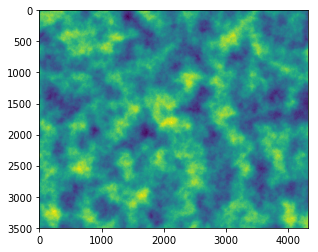

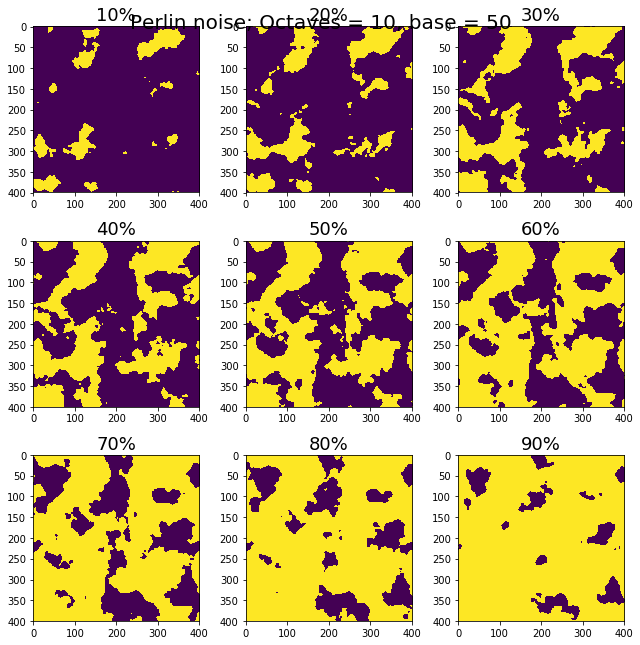

In [20]:
# Benchmark time
from noise import snoise3
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask = np.zeros(shape)
octaves = 10
seed = 1500
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask[x,y] = snoise3(x/freq, y/freq, seed, octaves)      
            
plt.imshow(cloudMask)

print('Cloud generation time for '+str(shape)+' size image: '+ timer(start_time, time.time()))

plt.figure(figsize=(9,12))
columns = 3
images = [img_sum<np.percentile(img_sum, 10),
          img_sum<np.percentile(img_sum, 20),
          img_sum<np.percentile(img_sum, 30),
         img_sum<np.percentile(img_sum, 40),
          img_sum<np.percentile(img_sum, 50),
         img_sum<np.percentile(img_sum, 60),
          img_sum<np.percentile(img_sum, 70),
         img_sum<np.percentile(img_sum, 80),
         img_sum<np.percentile(img_sum, 90)]
titles = ['10%', '20%', '30%','40%','50%',
         '60%','70%','80%','90%']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
    plt.suptitle('Perlin noise; Octaves = 10, base = 50', fontsize=20)
    plt.tight_layout()

### Notes:
 - Octaves = 10, with persistence = 0.5 and lacunarity = 2.0 (defaults), are good settings. There isn't a seed parameter, but the base parameter can be changed to generate different clouds with the same settings.

----------------------------

### Making thinner clouds
Smaller clouds are also problematic in flood detection, and the model might do better at predicting because the nearest clear pixels will be closer and therefore more similar.

Can make smaller, more frequent clouds appear by changing the frequency (in this case, modifying the earlier frequency formula which was based on the octaves)

In [2]:
import sys
from noise import pnoise2, snoise2
from math import sqrt
import rasterio
import matplotlib.pyplot as plt

path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/'
with rasterio.open(path+'stack/stack.tif') as ds:
    shape = ds.shape
    print(shape)

# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

(3501, 4322)


In [14]:
start_time = time.time()

images = []
cloudMasks = []
octaves = [5, 7, 10, 15, 20, 25, 30, 35, 40]
for i, oct in enumerate(octaves):
    cloudMask = np.zeros(shape)
    freq = np.ceil(sqrt(np.sum(shape)/2)) * oct
    for y in range(shape[1]):
        for x in range(shape[0]):
            cloudMask[x,y] = snoise2(x/freq, y/freq, oct)
            cloudMasks.append(cloudMask)
            
print('Cloud generation time for '+str(shape)+' size image: '+ timer(start_time, time.time()))

Cloud generation time for (3501, 4322) size image: 00:09:00.92


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cloudMask < np.percentile(cloudMask, 5))

### Dynamical cloud cover percentages
Unfortunately, even though thresholding with the percentile may create cloud masks that are at X% cloud cover, if this mask is applied to images with real clouds that were removed (say, Y%), then the actual cloud cover becomes (X+Y%). So we need a cloud cover mask that somehow dynamically thresholds based on the number of non-NaN values in the satellite image.

In [3]:
import sys
import random
import numpy as np
from noise import pnoise2, snoise2, snoise3
from math import sqrt
import rasterio
import matplotlib.pyplot as plt

path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/'
with rasterio.open(path+'stack/stack.tif') as ds:
    shape = ds.shape
shape = (500,700)
octave = 5
cloudMask = np.zeros(shape)
seed = (random.randint(1,10000))
freq = np.ceil(sqrt(np.sum(shape))) * 2
for y in range(shape[1]):
    for x in range(shape[0]):
        cloudMask[x,y] = snoise3(x=x/freq, y=y/freq, z=seed, octaves=octave, persistence=0.5)

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\tf_intel_cpu\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


0.49993

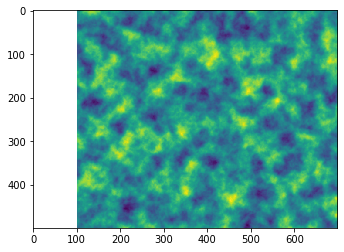

In [4]:
testmask = cloudMask.copy()
testmask[0:500, 0:100] = np.nan
plt.imshow(testmask)

p = testmask < np.nanpercentile(testmask, 50)
testmask[p] = np.nan
np.count_nonzero(testmask[~np.isnan(testmask)]) / (600*500) 

0.7101522476369146


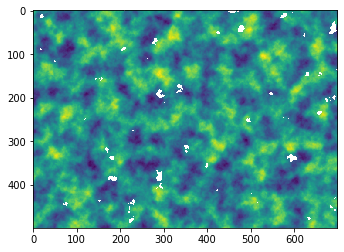

In [7]:
#==================== Create cloudmask
path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/'
with rasterio.open(path+'stack/stack.tif') as ds:
    shape = ds.shape
shape = (500,700)
octave = 5
cloudmask = np.zeros(shape)
seed = (random.randint(1,10000))
freq = np.ceil(sqrt(np.sum(shape))) * 2
for y in range(shape[1]):
    for x in range(shape[0]):
        cloudmask[x,y] = snoise3(x=x/freq, y=y/freq, z=seed, octaves=octave, persistence=0.5)
        
#==================== Mask cloudmask to match non-NaN shape of real image
# To do this, need to create a cloud mask of "real" clouds to apply to image. Mimics cloud removal during preprocessing
real_cloudmask = np.zeros(shape)
seed = (random.randint(1,10000))
freq = np.ceil(sqrt(np.sum(shape))) * 2
for y in range(shape[1]):
    for x in range(shape[0]):
        real_cloudmask[x,y] = snoise3(x=x/freq, y=y/freq, z=seed, octaves=octave, persistence=0.5)
# real_cloudmask = real_cloudmask < np.nanpercentile(real_cloudmask, 10)
real_cloudmask = np.less(real_cloudmask, np.nanpercentile(real_cloudmask, 1), where=~np.isnan(real_cloudmask))

# Mask cloudmask
cloudmask[real_cloudmask] = np.nan
plt.imshow(cloudmask)
#==================== Threshold newly masked cloudmask
# Want this particular cloudmask at 50% cloud cover
total_pixels = np.count_nonzero(cloudmask[~np.isnan(cloudmask)])
# cloudmask = cloudmask < np.nanpercentile(real_cloudmask, 50)
cloudmask = np.less(cloudmask, np.nanpercentile(cloudmask, 70), where=~np.isnan(cloudmask))

# Testing if 50% of pixels are masked
clear_pixels = np.count_nonzero(cloudmask[~np.isnan(cloudmask)])
print(clear_pixels / total_pixels)

Testing dynamic cloud masking using real data. Here, we're returning the test data (cloudy pixels)

In [15]:
import sys
sys.path.append('../../')
from CPR.CPR.configs import data_path
import numpy as np
import osgeo
import rasterio

img = '4444_LC08_044034_20170222_1'
test = True
normalize = True
img_path = data_path / 'images' / img
stack_path = img_path / 'stack' / 'stack.tif'
trial = 'trial1'
pctl = 30

# load cloudmasks
clouds_dir = data_path / 'clouds' / 'random' / trial

clouds = np.load(clouds_dir / '{0}'.format(img + '_clouds.npy'))

# Check for any features that have all zeros/same value and remove. This only matters with the training data
# Get local image
with rasterio.open(str(stack_path), 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0))  # Not sure why the rasterio.read output is originally (D, W, H)

# Convert -999999 and -Inf to Nans
data[data == -999999] = np.nan
data[np.isneginf(data)] = np.nan
# Now remove NaNs (real clouds, ice, missing data, etc). from cloudmask
clouds[np.isnan(data[:, :, 0])] = np.nan

if test:
    cloudmask = clouds < np.nanpercentile(clouds, pctl)  # Data, data_vector, etc = pctl
if not test:
    cloudmask = clouds > np.nanpercentile(clouds, pctl)  # Data, data_vector, etc = 1 - pctl

# And mask clouds
data[cloudmask] = -999999

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


In [17]:
# The cloud masked pixels were converted to -999999 (not NaN like the preprocessing function)
# If cloud cover % is 30%, we want test / (train+test) to be 30%

train = np.where(data[:, :, 1]>-999999 & ~np.isnan(data[:, :, 1]), 1, 0)
test = np.where(data[:, :, 1]==-999999, 1, 0)
np.sum(test) / (np.sum(train) + np.sum(test))

C:\Users\ipdavies\AppData\Local\Continuum\anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


0.31003508876288904

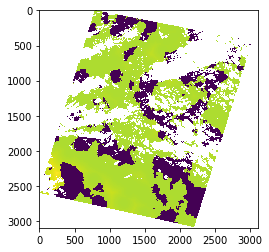

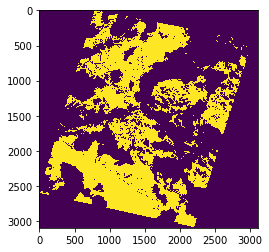

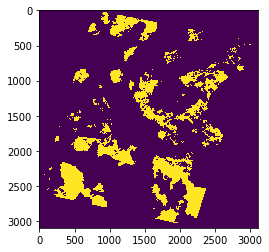

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.imshow(data[:,:,1])
plt.figure()
plt.imshow(train)
plt.figure()
plt.imshow(test)